In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%config Completer.use_jedi = False
import tensorflow as tf
from tensorflow import keras
#model = keras.models.load_model('myModel.h5')
model = keras.models.load_model('digit_model.h5')
from solver import solve, print_board

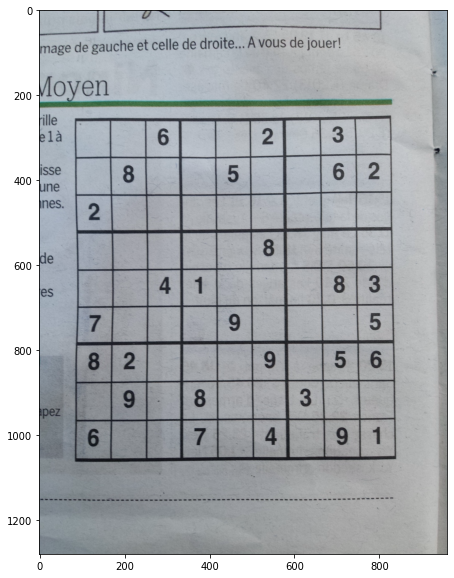

In [2]:
img = cv2.imread('v2_train/image1081.jpg')
plt.figure(figsize=(10,10))
plt.imshow(img, cmap = 'gray')

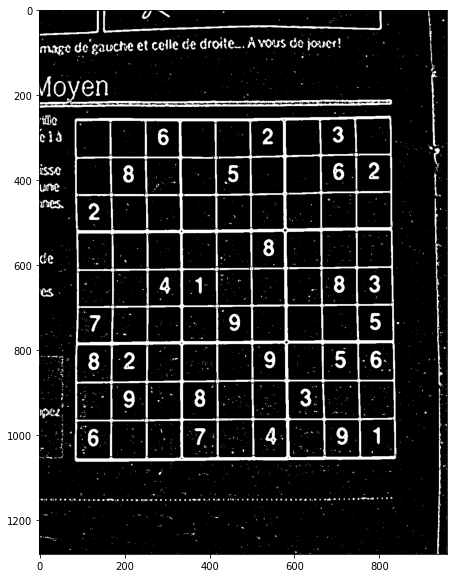

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 7)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap = 'gray')

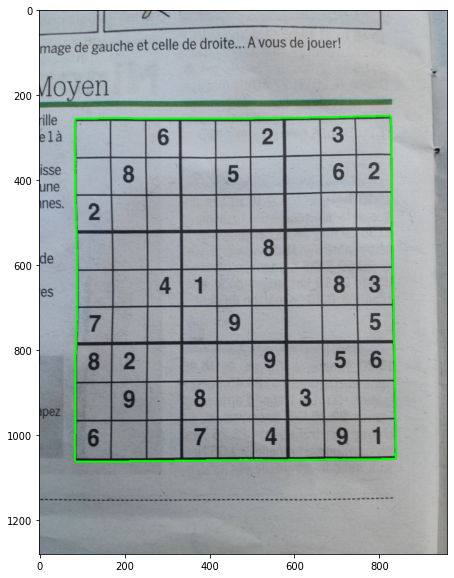

In [4]:
img_copy=img.copy()
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_area = 0
c = 0
for i in contours:
        area = cv2.contourArea(i)
        if area > 10000:
                if area > max_area:
                    max_area = area
                    best_cnt = i
                    img_copy = cv2.drawContours(img_copy, contours, c, (0, 255, 0), 3)
        c+=1
plt.figure(figsize=(10,10))
plt.imshow(img_copy, cmap='gray')

In [5]:
corner_amount=4
max_iter=200
coefficient = 1
contours = best_cnt
corners = None
while max_iter > 0 and coefficient >= 0:
    max_iter = max_iter - 1
    epsilon = coefficient * cv2.arcLength(contours, True)
    poly_approx = cv2.approxPolyDP(contours, epsilon, True)
    hull = cv2.convexHull(poly_approx)
    if len(hull) == corner_amount:
        corners = hull
    else:
        if len(hull) > corner_amount:
            coefficient += .01
        else:
            coefficient -= .01

In [6]:
corner1 = corners[np.argmin(corners.sum(axis=1).sum(axis=1))]
corner4 = corners[np.argmax(corners.sum(axis=1).sum(axis=1))]
height =  corner4[0][1] - corner1[0][1]
width =  corner4[0][0] - corner1[0][0]

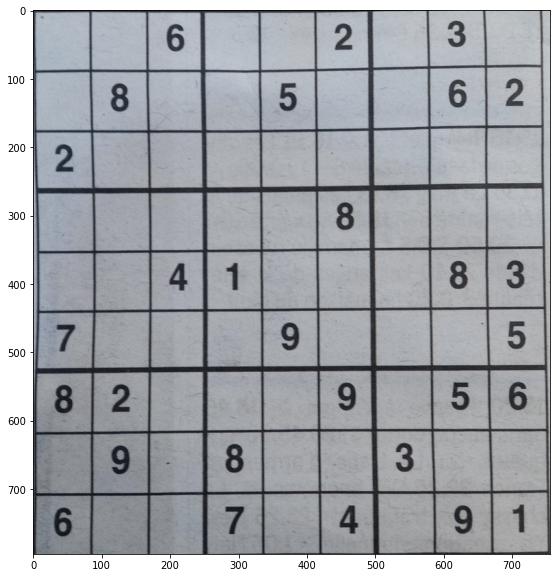

In [7]:
xmin=corner1[0][0]
ymin=corner1[0][1]
crop_img = img[ymin:ymin+height, xmin:xmin+width]
plt.figure(figsize=(10,10))
plt.imshow(crop_img)

In [8]:
# kernal_open = np.ones((2,2), dtype=np.uint8)
# crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
# #crop_img = cv2.medianBlur(crop_img, 5)
# crop_img = cv2.adaptiveThreshold(crop_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
# crop_img = cv2.morphologyEx(crop_img, cv2.MORPH_OPEN, kernal_open, iterations=1)
# plt.figure(figsize=(10,10))
# plt.imshow(crop_img, cmap = 'gray')

In [9]:
def largest_connected_component(image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    
    sizes = stats[:,cv2.CC_STAT_HEIGHT]
    max_label = 1
    if(len(sizes) <= 1):
        white_image = np.zeros(image.shape)
        white_image.fill(255)
        return white_image

    for i in range(nb_components):
        if sizes[i] >= 10 and sizes[i] <= 26:
            max_label = i

    img2 = np.zeros(output.shape)
    img2.fill(255)
    img2[output == max_label] = 0
    return img2

In [10]:
size = 9
sudoku_list = []
x_len = int(width/9)
y_len = int(height/9)
print(x_len, y_len)
pt1 = (0,0)
pt2 = (0+x_len, 0+y_len)
kernal_open = np.ones((2,2), dtype=np.uint8)
xp = int(x_len*0.1)
yp = int(y_len*0.1)
for xi in range(size):
    temp_list = []
    for yi in range(size):
        crop_cell = crop_img[pt1[1]:pt1[1]+y_len, pt1[0]:pt1[0]+x_len]
        crop_cell = crop_cell[yp:y_len-yp, xp:x_len-xp]
        crop_cell = cv2.resize(crop_cell, (28, 28))
        
        crop_cell = cv2.cvtColor(crop_cell, cv2.COLOR_BGR2GRAY)
        crop_cell = cv2.adaptiveThreshold(crop_cell,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,5,2)
        con,_ = cv2.findContours(crop_cell.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        area = [cv2.contourArea(v) for v in con]
        
        crop_cell = cv2.morphologyEx(crop_cell, cv2.MORPH_OPEN, kernal_open, iterations=1)
        digit_cell = largest_connected_component(crop_cell)
        digit_cell = digit_cell.astype('uint8')
        digit_cell = 255 - digit_cell
        crop_cell2 = np.expand_dims(digit_cell.reshape(28,28,1), axis=0)
        imS = cv2.resize(digit_cell.copy(), (500, 500)) 
           
#         print(np.max(model.predict_proba(crop_cell2/255)), model.predict_classes(crop_cell2/255)[0])
        if max(area) > 25:
            temp_list.append(model.predict_classes(crop_cell2/255)[0])
        else:
            temp_list.append(0)
        
        pt1 = (pt1[0]+x_len, pt1[1])
        pt2 = (pt2[0]+x_len, pt2[1])

    pt1 = (0, pt1[1]+y_len)
    pt2 = (x_len, pt2[1]+y_len)
    sudoku_list.append(temp_list)

84 88
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [11]:
import copy
unsolved = copy.deepcopy(sudoku_list)
solved = copy.deepcopy(sudoku_list)
print_board(unsolved)
print("------------------------------")
solve(solved)
print_board(solved)

0 0 6  | 0 0 2  | 0 3 0
0 8 0  | 0 5 0  | 0 6 2
2 0 0  | 0 0 0  | 0 0 0
- - - - - - - - - - - - - 
0 0 0  | 0 0 8  | 0 0 0
0 0 4  | 1 0 0  | 0 8 3
7 0 0  | 0 9 0  | 0 0 5
- - - - - - - - - - - - - 
8 2 0  | 0 0 9  | 0 5 6
0 9 0  | 8 0 0  | 3 0 0
6 0 0  | 7 0 4  | 0 9 1
------------------------------
5 7 6  | 9 8 2  | 1 3 4
1 8 3  | 4 5 7  | 9 6 2
2 4 9  | 6 3 1  | 5 7 8
- - - - - - - - - - - - - 
3 6 2  | 5 4 8  | 7 1 9
9 5 4  | 1 7 6  | 2 8 3
7 1 8  | 2 9 3  | 6 4 5
- - - - - - - - - - - - - 
8 2 7  | 3 1 9  | 4 5 6
4 9 1  | 8 6 5  | 3 2 7
6 3 5  | 7 2 4  | 8 9 1


In [12]:
def draw_number(cell, number):
    cv2.putText(cell, str(number), (20,65), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    return cell

In [13]:
pt1 = (0,0)
pt2 = (0+x_len, 0+y_len)
crop_img_updated = crop_img.copy()
for xi in range(size):
    for yi in range(size):
        crop_cell = crop_img_updated[pt1[1]:pt1[1]+y_len, pt1[0]:pt1[0]+x_len]
        if unsolved[xi][yi] == 0:
            crop_img_updated[pt1[1]:pt1[1]+y_len, pt1[0]:pt1[0]+x_len] = draw_number(crop_cell, solved[xi][yi])
        pt1 = (pt1[0]+x_len, pt1[1])
        pt2 = (pt2[0]+x_len, pt2[1])

    pt1 = (0, pt1[1]+y_len)
    pt2 = (x_len, pt2[1]+y_len)

84 88
[[0 0 6 0 0 2 0 3 0]
 [0 8 0 0 5 0 0 6 2]
 [2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0]
 [0 0 4 1 0 0 0 8 3]
 [7 0 0 0 9 0 0 0 5]
 [8 2 0 0 0 9 0 5 6]
 [0 9 0 8 0 0 3 0 0]
 [6 0 0 7 0 4 0 9 1]]

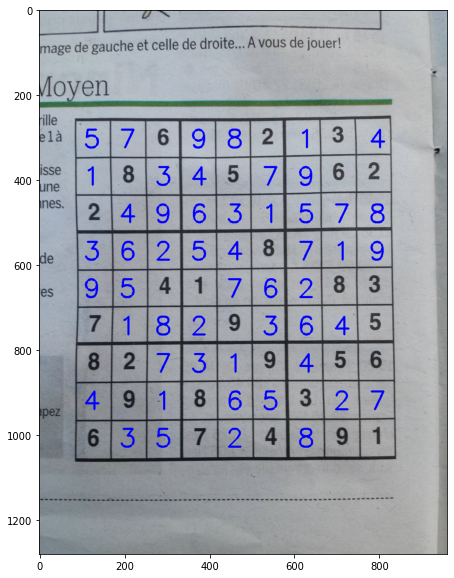

In [14]:
img[ymin:ymin+height, xmin:xmin+width] = crop_img_updated
plt.figure(figsize=(10,10)) 
plt.imshow(img)